# Gradient Boosting training

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, brier_score_loss
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

dataset_path = Path("../data/processed/dataset_final.csv")
if not dataset_path.exists():
	raise FileNotFoundError(f"Le fichier {dataset_path} est introuvable. Vérifiez le chemin ou générez le dataset avant de continuer.")

# Charger le dataset final
df = pd.read_csv(dataset_path)

print(f"📊 Dataset shape: {df.shape}")
print(f"📅 Période: {df['Date'].min()} à {df['Date'].max()}")
print(f"⚽ Distribution des résultats:")
print(df['Target'].value_counts(normalize=True))

df.head()

📊 Dataset shape: (1386, 24)
📅 Période: 2019-07-26 à 2024-08-10
⚽ Distribution des résultats:
Target
H    0.435065
A    0.326118
D    0.238817
Name: proportion, dtype: float64


,Date,HomeTeam,AwayTeam,Target,home_avg_goals_scored,home_avg_goals_conceded,home_avg_shots,home_avg_shots_target,home_avg_corners,home_win_rate,...,away_avg_shots_target,away_avg_corners,away_win_rate,away_form,form_difference,goal_difference,home_shot_efficiency,away_shot_efficiency,home_advantage,Target_encoded
0,2019-07-26,Genk,Kortrijk,H,1.8,1.6,15.8,5.6,5.6,0.6,...,4.2,7.8,0.4,1.4,0.6,0.6,0.333333,0.318182,0.2,0
1,2019-07-27,Cercle Brugge,Standard,A,1.2,2.0,15.8,5.2,7.6,0.2,...,1.8,2.8,0.4,1.4,-0.6,-0.6,0.309524,0.166667,-0.2,2
2,2019-07-27,St Truiden,Mouscron,A,1.2,2.8,8.6,3.2,3.4,0.0,...,3.8,5.2,0.2,0.8,-0.2,-1.0,0.333333,0.260274,-0.2,2
3,2019-07-27,Waregem,Mechelen,A,2.2,2.2,10.2,5.0,4.4,0.2,...,5.2,4.4,0.4,1.4,-0.6,0.0,0.446429,0.361111,-0.2,2
4,2019-07-27,Waasland-Beveren,Club Brugge,A,2.0,2.2,13.8,6.6,5.0,0.4,...,6.4,5.2,0.6,1.8,-0.6,-0.8,0.445946,0.372093,-0.2,2


## Division temporel du dataset

In [2]:
# Convertir la date et trier
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Division temporelle : 80% train, 20% test
split_date = df['Date'].quantile(0.8)
train_data = df[df['Date'] <= split_date]
test_data = df[df['Date'] > split_date]

print(f"📈 Train: {len(train_data)} matchs (jusqu'au {split_date.date()})")
print(f"📊 Test: {len(test_data)} matchs (à partir du {split_date.date()})")

# Préparation des features et target
feature_cols = [col for col in df.columns if col not in ['Date', 'HomeTeam', 'AwayTeam', 'Target', 'Target_encoded']]

X_train = train_data[feature_cols]
y_train = train_data['Target_encoded']
X_test = test_data[feature_cols]
y_test = test_data['Target_encoded']

print(f"🎯 Features utilisées: {len(feature_cols)}")
print(f"📊 Shape train: {X_train.shape}")
print(f"📊 Shape test: {X_test.shape}")

📈 Train: 1109 matchs (jusqu'au 2023-08-27)
📊 Test: 277 matchs (à partir du 2023-08-27)
🎯 Features utilisées: 19
📊 Shape train: (1109, 19)
📊 Shape test: (277, 19)


## Entrainement et évaluation du modèle

In [3]:
# Normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

🎯 Accuracy: 51.986 %

📊 Classification Report:
              precision    recall  f1-score   support

        Home       0.55      0.73      0.63       125
        Draw       0.35      0.09      0.15        74
        Away       0.50      0.59      0.54        78

    accuracy                           0.52       277
   macro avg       0.47      0.47      0.44       277
weighted avg       0.48      0.52      0.48       277



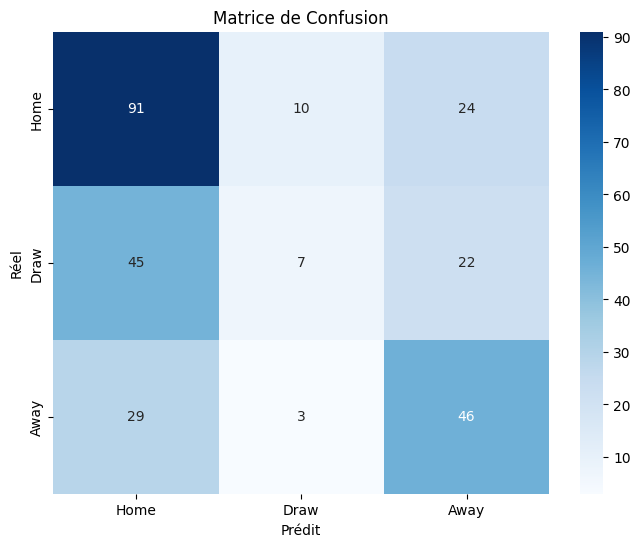

📊 Probabilités prédites:
       Home      Draw      Away
0  0.531342  0.211043  0.257615
1  0.484962  0.229288  0.285749
2  0.495102  0.273388  0.231510
3  0.254603  0.241035  0.504362
4  0.300141  0.300087  0.399772


In [4]:
# Entraînement Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42,
    min_samples_split = 5,
    learning_rate=0.05,
)

gb_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred = gb_model.predict(X_test_scaled)
y_pred_proba = gb_model.predict_proba(X_test_scaled)

# Évaluation
from sklearn.metrics import accuracy_score, classification_report
accuracy = (accuracy_score(y_test, y_pred)) * 100

print(f"🎯 Accuracy: {accuracy:.3f} %")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Home', 'Draw', 'Away']))

# Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Home', 'Draw', 'Away'],
            yticklabels=['Home', 'Draw', 'Away'])
plt.title('Matrice de Confusion')
plt.ylabel('Réel')
plt.xlabel('Prédit')
plt.show()

# Probabilités prédites
y_pred_proba = pd.DataFrame(y_pred_proba, columns=['Home', 'Draw', 'Away'])
print("📊 Probabilités prédites:")
print(y_pred_proba.head())


## Brier score

In [6]:
# Brier Score pour chaque classe
for i, class_name in enumerate(['Home', 'Draw', 'Away']):
    y_binary = (y_test == i).astype(int)
    brier_class = brier_score_loss(y_binary, y_pred_proba.iloc[:, i])
    print(f"📉 Brier Score {class_name}: {brier_class:.4f}")




📉 Brier Score Home: 0.2422
📉 Brier Score Draw: 0.2051
📉 Brier Score Away: 0.1803


## Save model

In [9]:
import joblib

# Sauvegarder le modèle
model_path = Path("../models/gb_model.pkl")
joblib.dump(gb_model, model_path)
print(f"💾 Modèle sauvegardé à {model_path}")

💾 Modèle sauvegardé à ..\models\gb_model.pkl
